The article "prediction of Wine Quality Using Machine Learning" states that it used the red wine dataset. Paragraph 2.1 mentions that the dataset contains 4898 entries. When examing the datasets, this number corresponds to the white wine dataset. This confusion in consistent throughout the article. From this point on the white wine dataset will be used, eventhough the article states that the red wine dataset is used.

In [11]:
from tabnanny import verbose

# used libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from shap import initjs, waterfall_plot

print(tf.__version__)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.stats import pearsonr
from keras.optimizers import Adam

2.12.0


In [12]:
#import the winequality dataset

# Define the relative path to the CSV file
relative_path = 'wine+quality/winequality-white.csv'
# Read the CSV file using pandas
wine_df = pd.read_csv(relative_path, delimiter=';')

scaler = StandardScaler()
wine_scaled_df = pd.DataFrame(scaler.fit_transform(wine_df), columns=wine_df.columns)

X = wine_scaled_df.drop('quality', axis=1)
y = wine_df['quality']

len(X)


4898

Feature scaling was applied using standardization. Following code standardizes the dataset.

Create the train, validation and test set from the original data set

In [13]:
# Step 1: Split the data into training and temporary sets
# The training set will contain 60% of the data, and the temporary set will contain 40% of the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)

# Step 1: Split the data into training and temporary sets
# The training set will contain 60% of the data, and the temporary set will contain 40% of the data
X_test, X_validate, y_test, y_validate = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

print(f'Original set and target shape: {X.shape} {y.shape}')
print(f'Training set and target shape: {X_train.shape} {y_train.shape}')
print(f'Validation set and target shape: {X_validate.shape} {y_validate.shape}')
print(f'Test set and target shape: {X_test.shape} {y_test.shape}')


Original set and target shape: (4898, 11) (4898,)
Training set and target shape: (2938, 11) (2938,)
Validation set and target shape: (980, 11) (980,)
Test set and target shape: (980, 11) (980,)


Create a ANN model with:
- 1 input layer with 11 neurons
- 3 hidden layers with 15 neurons
- 1 output layer with 1 neuron

In [14]:
# Initialize the Sequential model
model = tf.keras.Sequential()
# model = Sequential()

#add layers
model.add(Input(shape=(11,))) # input layer
model.add(Dense(15, activation='relu')) # first hidden layer
model.add(Dense(15, activation='relu')) # second hidden layer
model.add(Dense(15, activation='relu')) # third hidden layer
model.add(Dense(1, activation='linear')) # Output layer

# Compile the model with mean squared error loss and Adam optimizer
# Also include mean squared error, mean absolute error, and mean absolute percentage error as metrics
model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])

# Print the summary of the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 15)                180       
                                                                 
 dense_5 (Dense)             (None, 15)                240       
                                                                 
 dense_6 (Dense)             (None, 15)                240       
                                                                 
 dense_7 (Dense)             (None, 1)                 16        
                                                                 
Total params: 676
Trainable params: 676
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Train the model with the training data
# - epochs: Number of times the model will iterate over the entire training dataset
# - batch_size: Number of samples per gradient update
# - validation_data: Data on which to evaluate the loss and metrics at the end of each epoch
# - verbose: Verbosity mode (1 = progress bar)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_validate, y_validate), verbose=0)


In [16]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test, verbose=0)

# Print the test loss
print("Test loss:", test_loss)

# Make predictions on the test data
y_train_pred = model.predict(X_train, verbose=0).flatten()
y_test_pred = model.predict(X_test, verbose=0).flatten()

np.shape(y_train_pred)


Test loss: [0.5717562437057495, 0.5717562437057495, 0.5863847732543945, 10.066690444946289]


(2938,)

In [17]:
# Function to calculate metrics (R, MSE, MAPE)
def calculate_metrics(y_true, y_pred):
    # Calculate R (Pearson correlation coefficient)
    r, _ = pearsonr(y_true, y_pred)

    # Calculate MSE
    mse = mean_squared_error(y_true, y_pred)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return r, mse, mape

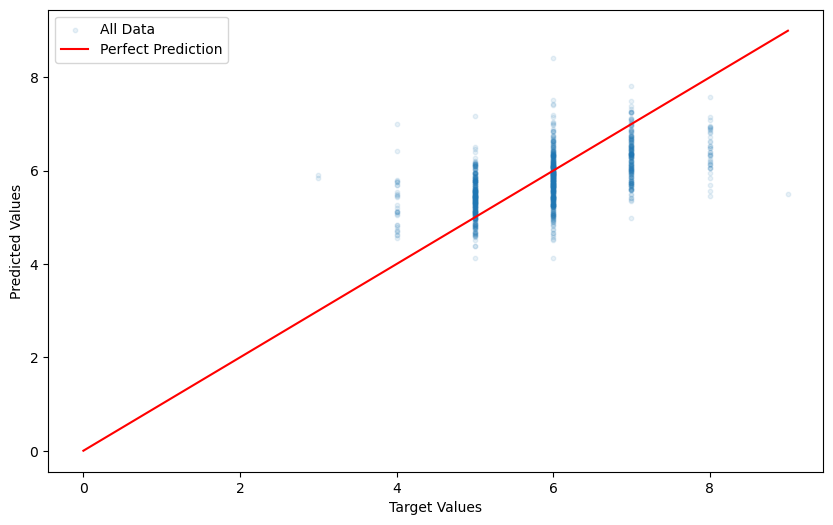

In [18]:

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, s=10, alpha=0.1, label='All Data')
plt.plot([0,9],[0,9],color='red', linestyle='-', label='Perfect Prediction')
plt.xlabel('Target Values')
plt.ylabel('Predicted Values')
plt.legend()

In [19]:
# Calculate metrics for training data set
train_r, train_mse, train_mape = calculate_metrics(y_train, y_train_pred)

# # Calculate metrics for testing data set
test_r, test_mse, test_mape = calculate_metrics(y_test, y_test_pred)

print(f"Training Data Metrics: R: {train_r:.4f}, MSE: {train_mse:.4f}, MAPE: {train_mape:.4f}")
print(f"Testing Data Metrics: R: {test_r:.4f}, MSE: {test_mse:.4f}, MAPE: {test_mape:.4f}")

Training Data Metrics: R: 0.6636, MSE: 0.4562, MAPE: 0.0918
Testing Data Metrics: R: 0.5488, MSE: 0.5718, MAPE: 0.1007


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 50/50 [03:54<00:00,  4.69s/it]


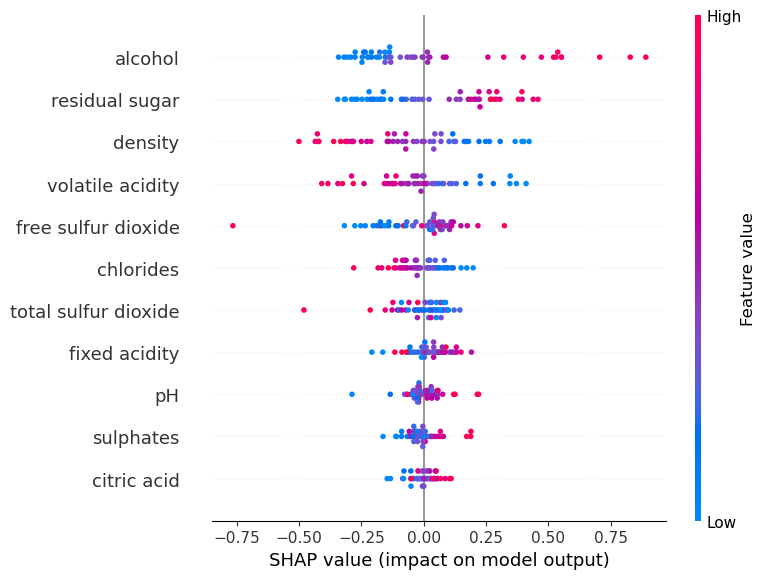

In [20]:
import shap

background_data = X_train.sample(200, random_state=1)
test_data = X_test.sample(50, random_state=1)

def predict_wrapper(X):
    return model.predict(X, verbose=0).flatten()

explainer = shap.KernelExplainer(predict_wrapper, background_data)
shap_values = explainer.shap_values(test_data)

shap.summary_plot(shap_values, test_data, feature_names=X.columns)

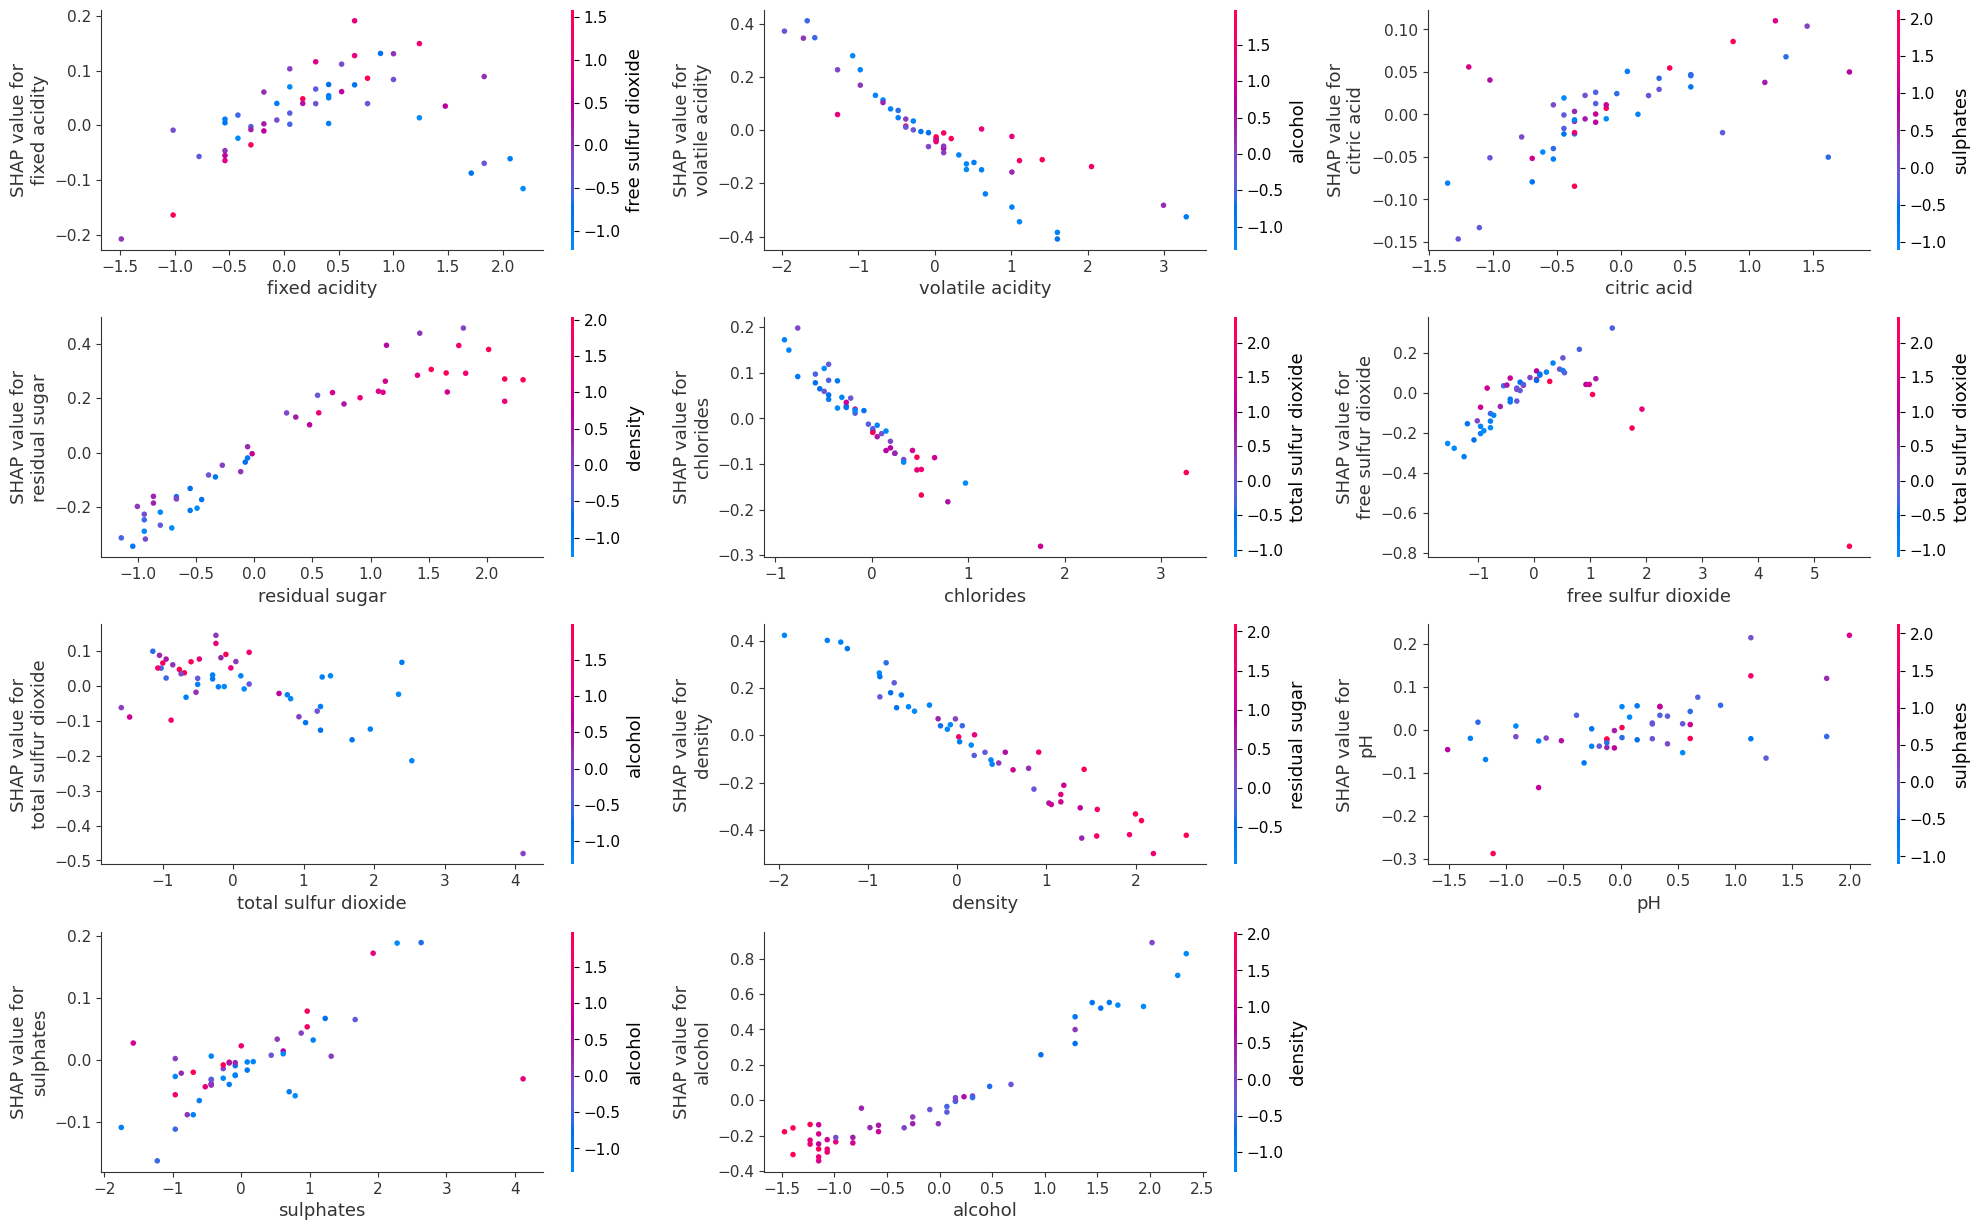

In [21]:
# print the dependence plot for all the features
fig, ax = plt.subplots(5, 3, figsize=(20, 15))
ax = ax.flatten()

for i in range(11):
    shap.dependence_plot(i, shap_values, test_data, feature_names=X.columns, ax=ax[i], show=False)

# Remove any unused subplots
for j in range(11, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()
